## Ambil Data

In [1]:
# Import library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import shutil
import random
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFilter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Path untuk dataset lokal di komputer Anda
base_dir = r'D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogram Matched'

In [2]:
def find_and_delete_desktop_ini(directory):
    # Traverse through all directories and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is desktop.ini
            if file.lower() == 'desktop.ini':
                file_path = os.path.join(root, file)
                try:
                    # Delete the file
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except Exception as e:
                    print(f"Failed to delete {file_path}: {e}")

find_and_delete_desktop_ini(base_dir)

### Buat Dataframe dan batasi jumlah data menjadi 1000

In [3]:
def create_dataframe(image_dir, total_images):
     # List untuk menyimpan path gambar dan labelnya
    image_paths = []
    labels = []
    
    # Mendapatkan daftar kelas bunga
    coffee_classes = os.listdir(image_dir)
    num_classes = len(coffee_classes)
    
    # Tentukan jumlah gambar per kelas berdasarkan total gambar yang diinginkan
    images_per_class = total_images // num_classes
    
    # Iterasi melalui setiap kelas bunga
    for flower_class in coffee_classes:
        class_dir = os.path.join(image_dir, flower_class)
        
        # Ambil semua file gambar dalam folder kelas
        image_files = os.listdir(class_dir)
        
        # Acak urutan gambar
        random.shuffle(image_files)
        
        # Batasi jumlah gambar yang diambil berdasarkan images_per_class
        selected_images = image_files[:images_per_class]
        
        # Tambahkan path gambar dan label ke list
        for image_file in selected_images:
            image_path = os.path.join(class_dir, image_file)
            image_paths.append(image_path)
            labels.append(flower_class)
    
    # Membuat dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    return df

# Membuat dataframe untuk train, valid, dan test
df = create_dataframe(base_dir,3180)

# Split the dataframe into train (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Further split the train set into train (80%) and validation (20%) sets
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Menampilkan informasi dataframe
print("Dataframe:\n", df.head())

Dataframe:
                                           image_path            label
0  D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogr...  R25 (Very Dark)
1  D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogr...  R25 (Very Dark)
2  D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogr...  R25 (Very Dark)
3  D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogr...  R25 (Very Dark)
4  D:\Kuliah\Matkul\Semester 7\TA\Dataset\Histogr...  R25 (Very Dark)


### Batasi Jumlah Data

## Visualisasi Data

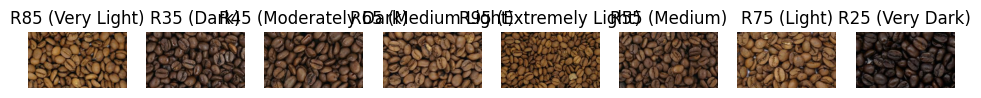

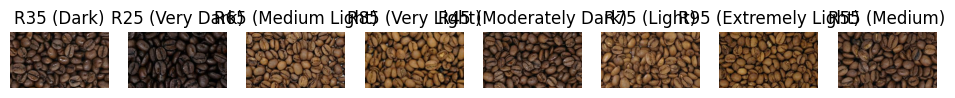

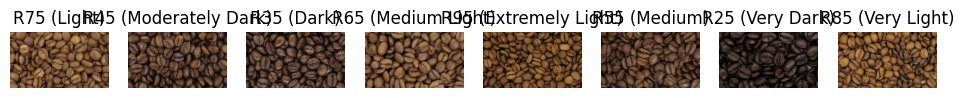

In [4]:
def show_sample_images(df, num_classes=10):
    # Ambil nama unik dari label (kelas)
    unique_classes = df['label'].unique()
    
    # Buat figure untuk menampilkan citra
    plt.figure(figsize=(15, 15))
    
    for idx, flower_class in enumerate(unique_classes[:num_classes]):
        # Ambil citra pertama dari kelas ini
        sample_image_path = df[df['label'] == flower_class]['image_path'].iloc[0]
        
        # Baca citra menggunakan OpenCV
        image = cv2.imread(sample_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengubah BGR ke RGB
        
        # Menampilkan citra
        plt.subplot(1, num_classes, idx+1)
        plt.imshow(image)
        plt.title(flower_class)
        plt.axis('off')  # Menghilangkan sumbu
    
    plt.show()

# Menampilkan contoh citra dari dataframe training
show_sample_images(train_df)

# Menampilkan contoh citra dari dataframe validasi
show_sample_images(val_df)

# Menampilkan contoh citra dari dataframe testing
show_sample_images(test_df)


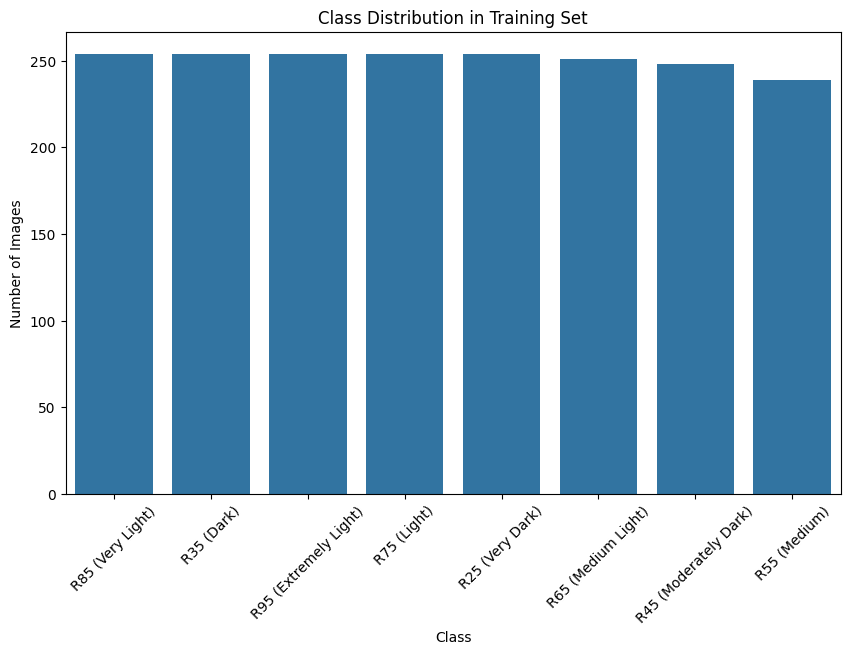

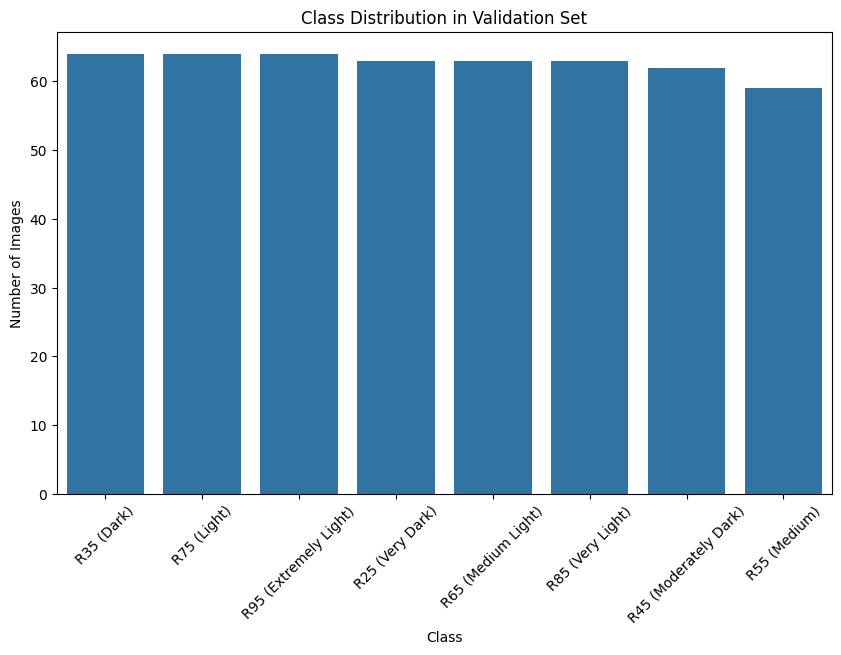

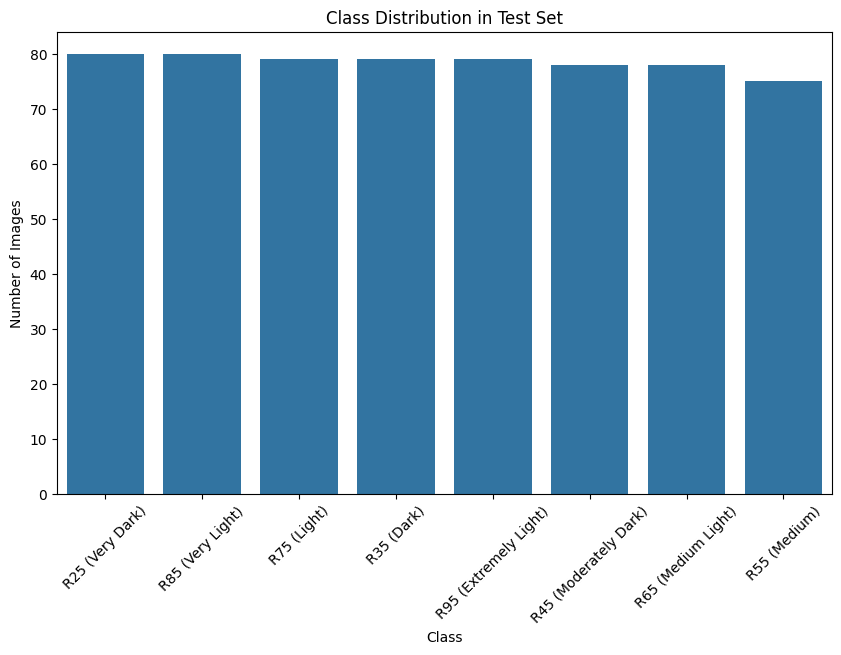

In [5]:
def visualize_class_distribution(df, title):
    # Menghitung jumlah gambar per kelas
    class_counts = df['label'].value_counts()

    # Membuat plot bar menggunakan matplotlib dan seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

# Visualisasi untuk train_df
visualize_class_distribution(train_df, 'Class Distribution in Training Set')

# Visualisasi untuk val_df
visualize_class_distribution(val_df, 'Class Distribution in Validation Set')

# Visualisasi untuk test_df
visualize_class_distribution(test_df, 'Class Distribution in Test Set')


## Pra-Pemrosesan

In [6]:
# Set random seeds for reproducibility
seed_value = 42  # You can choose any integer value

# Set seeds
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Fungsi-fungsi pra-pemrosesan 
def reshape_images(images):
    return np.array([np.array(image).reshape(224, 224, 3) for image in images])

def enhance_image(image, factor=2.0):
    random.seed(seed_value)
    pil_image = Image.fromarray(image)
    sharpened_image = pil_image.filter(ImageFilter.SHARPEN)
    return np.array(sharpened_image)

def reduce_noise(image, ksize=5):
    random.seed(seed_value)
    # Mengurangi noise menggunakan GaussianBlur
    denoised_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return denoised_image

def increase_contrast(image, alpha=1.5, beta=0):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def one_hot_encode_labels(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes=num_classes)

In [7]:
def is_valid_file(file_name):
    return file_name.endswith(('.png', '.jpg', '.jpeg', '.JPG'))

def preprocess(df, preprocess_methods):
    processed_images = []
    labels = df['label'].tolist()  # Store labels
    
    for image_path in df['image_path']:
        # Check if the file is an image
        if not is_valid_file(image_path):
            print(f"Skipping non-image file: {image_path}")
            continue
        
        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Error: Image file does not exist at {image_path}.")
            continue
        
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image at {image_path}.")
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Resize the image to 224x224
        image = cv2.resize(image, (224, 224))

        # Check if all preprocessing methods should be applied
        if 'all' in preprocess_methods:
            image = enhance_image(image)
            image = reduce_noise(image)
            image = increase_contrast(image)
        else:
            # Preprocess according to selected methods
            if 'enhance' in preprocess_methods:
                image = enhance_image(image)
            if 'denoise' in preprocess_methods:
                image = reduce_noise(image)
            if 'contrast' in preprocess_methods:
                image = increase_contrast(image)

        # Add the processed image to the list
        processed_images.append(image)
    
    return processed_images, labels


In [8]:
# Image Enhancement
enhanced_train, train_labels = preprocess(train_df, 'enhance')
enhanced_val, val_labels = preprocess(val_df, 'enhance')
enhanced_test, test_labels = preprocess(test_df, 'enhance')

# Noise Removal
denoised_train, train_labels = preprocess(train_df,'denoise')
denoised_val, val_labels = preprocess(val_df,'denoise')
denoised_test, test_labels = preprocess(test_df,'denoise')

# Increase Contrast
contrasted_train, train_labels = preprocess(train_df, 'contrast')
contrasted_val, val_labels = preprocess(val_df, 'contrast')
contrasted_test, test_labels = preprocess(test_df, 'contrast')

# Do it All
all_train, train_labels = preprocess(train_df, 'all')
all_val, val_labels = preprocess(val_df, 'all')
all_test, test_labels = preprocess(test_df, 'all')


## Model

### Inisialisasi Arsitektur ResNet50

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set KERAS_HOME to your desired directory
os.environ['KERAS_HOME'] = 'D:/keras_models'  # Change this to your preferred path


def create_resnet50_model(input_shape=(224, 224, 3), num_classes=15, model_name="ResNet50"):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions, name=model_name)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model with a custom name
model = create_resnet50_model(input_shape=(224, 224, 3), num_classes=8, model_name="ResNet50")

# Menampilkan ringkasan model
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
# simpan weight awal untuk me-reset setelah training suatu metode

initial_weights_filepath = 'initial_weights.ckpt'
model.save_weights(initial_weights_filepath)

## Training

In [24]:
batchsize = 16
num_epochs = 25

# Function to load images from dataframe without preprocessing
def load_images(df):
    images = []
    labels = []
    
    for image_path, label in zip(df['image_path'], df['label']):
        # Read image using OpenCV
        image = cv2.imread(image_path)
        
        # Check if the image is loaded successfully
        if image is None:
            print(f"Skipping image {image_path} as it could not be loaded.")
            continue  # Skip this image and label
        
        try:
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image to 224x224
            image = cv2.resize(image, (224, 224))
            
            # Append the image and the corresponding label to the list
            images.append(image)
            labels.append(label)
        
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue  # Skip this image and label if there's an error
    
    return np.array(images), np.array(labels)


### Tanpa pra-pemrosesan

In [25]:
# Load images without preprocessing
train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)
test_images, test_labels = load_images(test_df)

# Ensure that images and labels have matching sizes
assert len(train_images) == len(train_labels), f"Train images and labels mismatch: {len(train_images)} images, {len(train_labels)} labels"
assert len(val_images) == len(val_labels), f"Validation images and labels mismatch: {len(val_images)} images, {len(val_labels)} labels"
assert len(test_images) == len(test_labels), f"Test images and labels mismatch: {len(test_images)} images, {len(test_labels)} labels"

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

# Normalize labels to one-hot encoding
num_classes = len(label_mapping)  # Number of unique classes
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")


Train images shape: (2008, 224, 224, 3), Train labels shape: (2008, 8)
Validation images shape: (502, 224, 224, 3), Validation labels shape: (502, 8)


In [26]:
# Train the CNN model on unprocessed images (only normalized)
history_no_preprocessing = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,  
    verbose=1,  
)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy without preprocessing: {test_accuracy}")


Epoch 1/25
126/126 [==============================] - 13s 102ms/step - loss: 0.1895 - accuracy: 0.9407 - val_loss: 0.8504 - val_accuracy: 0.7311
Epoch 2/25
126/126 [==============================] - 13s 99ms/step - loss: 0.0646 - accuracy: 0.9771 - val_loss: 1.1209 - val_accuracy: 0.7888
Epoch 3/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0586 - accuracy: 0.9766 - val_loss: 0.3374 - val_accuracy: 0.8765
Epoch 4/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0207 - accuracy: 0.9905 - val_loss: 0.4221 - val_accuracy: 0.8486
Epoch 5/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.8705 - val_accuracy: 0.7629
Epoch 6/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0167 - accuracy: 0.9960 - val_loss: 0.3963 - val_accuracy: 0.8765
Epoch 7/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.4906 - val_accura

In [27]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


20/20 [==============================] - 3s 132ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       1.00      1.00      1.00        80
           R35 (Dark)       0.99      0.99      0.99        79
R45 (Moderately Dark)       0.96      1.00      0.98        78
   R65 (Medium Light)       1.00      0.99      0.99        78
R95 (Extremely Light)       1.00      1.00      1.00        79
         R55 (Medium)       1.00      0.97      0.99        75
          R75 (Light)       0.99      1.00      0.99        79
      R25 (Very Dark)       1.00      0.99      0.99        80

             accuracy                           0.99       628
            macro avg       0.99      0.99      0.99       628
         weighted avg       0.99      0.99      0.99       628

Accuracy: 0.9920
Precision: 0.9922
Recall: 0.9920
F1-Score: 0.9921


In [28]:
# Save history for comparison later
history_no_preprocessing_dict = {
    'accuracy': history_no_preprocessing.history['accuracy'],
    'val_accuracy': history_no_preprocessing.history['val_accuracy'],
    'loss': history_no_preprocessing.history['loss'],
    'val_loss': history_no_preprocessing.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


#### Confusion Matrix

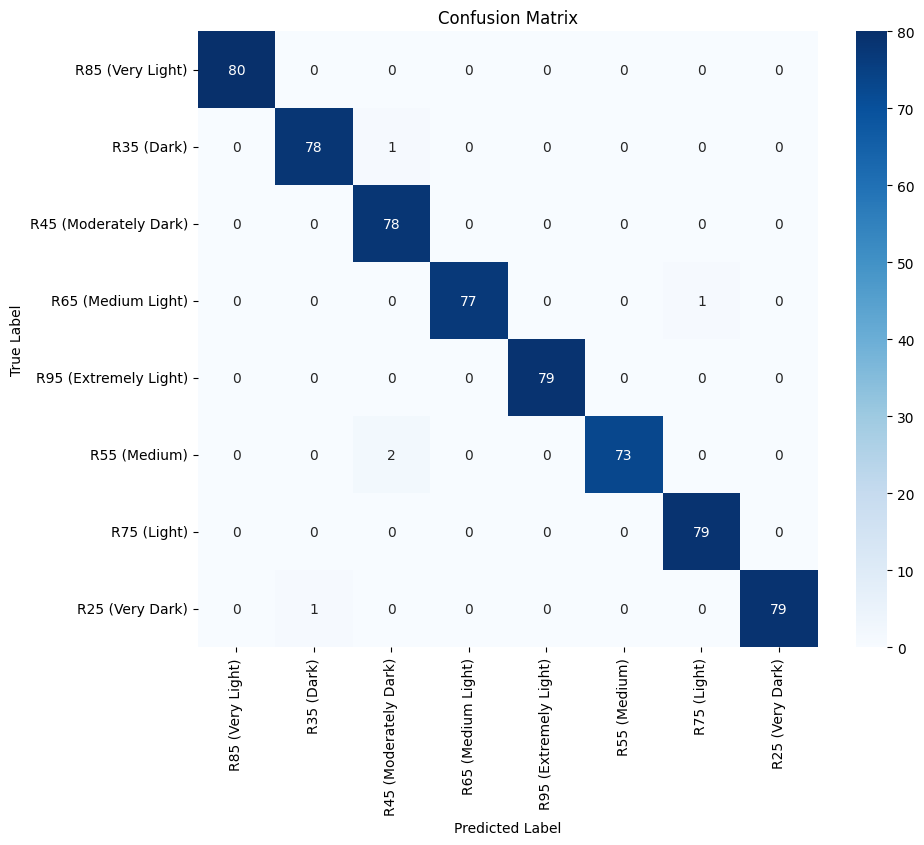

In [29]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Image Enhancement

In [30]:
# Load images with Image Enhancement

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

num_classes = len(train_df['label'].unique())

# One-hot encode labels
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

# Reshape the images to the desired shape
enhanced_train = reshape_images(enhanced_train)
enhanced_val = reshape_images(enhanced_val)
enhanced_test = reshape_images(enhanced_test)

In [31]:
# reset weight
model.load_weights(initial_weights_filepath)

# Train the CNN model on unprocessed images (only normalized)
history_enhance= model.fit(
    enhanced_train, train_labels,
    validation_data=(enhanced_val, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,    
    verbose=1,
)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(enhanced_test, test_labels)
print(f"Test Accuracy without preprocessing: {test_accuracy}")

Epoch 1/25
126/126 [==============================] - 13s 104ms/step - loss: 1.3792 - accuracy: 0.7480 - val_loss: 0.2964 - val_accuracy: 0.9064
Epoch 2/25
126/126 [==============================] - 13s 104ms/step - loss: 0.1857 - accuracy: 0.9323 - val_loss: 0.3092 - val_accuracy: 0.8825
Epoch 3/25
126/126 [==============================] - 12s 98ms/step - loss: 0.1489 - accuracy: 0.9512 - val_loss: 0.1313 - val_accuracy: 0.9602
Epoch 4/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0704 - accuracy: 0.9791 - val_loss: 0.0933 - val_accuracy: 0.9701
Epoch 5/25
126/126 [==============================] - 13s 99ms/step - loss: 0.0467 - accuracy: 0.9885 - val_loss: 0.0890 - val_accuracy: 0.9582
Epoch 6/25
126/126 [==============================] - 13s 101ms/step - loss: 0.0287 - accuracy: 0.9945 - val_loss: 0.0713 - val_accuracy: 0.9741
Epoch 7/25
126/126 [==============================] - 13s 99ms/step - loss: 0.0199 - accuracy: 0.9980 - val_loss: 0.0788 - val_accur

In [32]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(enhanced_test, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(enhanced_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


ResourceExhaustedError: Graph execution error:

Detected at node 'ResNet50/conv2_block1_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\DHAFINDRA\AppData\Local\Temp\ipykernel_17724\913291533.py", line 8, in <module>
      y_pred = model.predict(test_images)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\DHAFINDRA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'ResNet50/conv2_block1_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,56,56,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node ResNet50/conv2_block1_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_19521]

In [33]:
# Save history for comparison later
history_enhance_dict = {
    'accuracy': history_enhance.history['accuracy'],
    'val_accuracy': history_enhance.history['val_accuracy'],
    'loss': history_enhance.history['loss'],
    'val_loss': history_enhance.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


#### Confusion Matrix

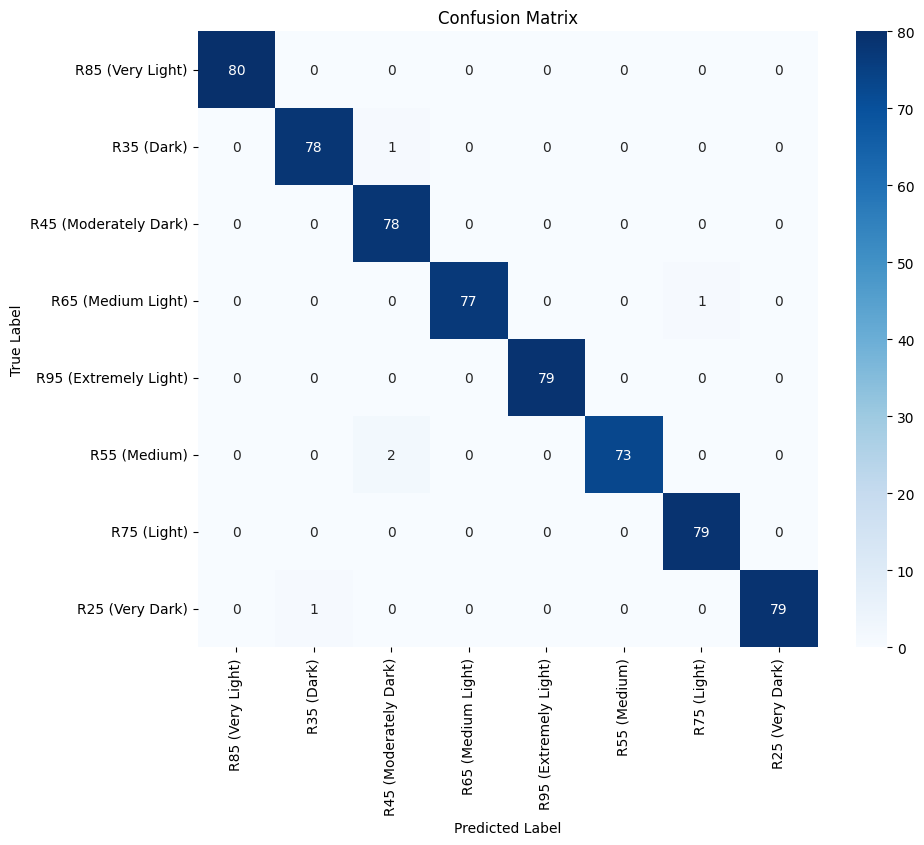

In [34]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Noise Reduction

In [35]:
# Load images with Noise Reduction

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

num_classes = len(train_df['label'].unique())

# One-hot encode labels
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

# Reshape the images to the desired shape
denoised_train = reshape_images(denoised_train)
denoised_val = reshape_images(denoised_val)
denoised_test = reshape_images(denoised_test)

In [36]:
# reset weight
model.load_weights(initial_weights_filepath)

# Train the CNN model on unprocessed images (only normalized)
history_denoise= model.fit(
    denoised_train, train_labels,
    validation_data=(denoised_val, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,   
    verbose=1,
)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(denoised_test, test_labels)
print(f"Test Accuracy without preprocessing: {test_accuracy}")

Epoch 1/25
126/126 [==============================] - 13s 104ms/step - loss: 0.9373 - accuracy: 0.7590 - val_loss: 0.2708 - val_accuracy: 0.9124
Epoch 2/25
126/126 [==============================] - 12s 99ms/step - loss: 0.1700 - accuracy: 0.9392 - val_loss: 0.1353 - val_accuracy: 0.9522
Epoch 3/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0745 - accuracy: 0.9821 - val_loss: 0.1274 - val_accuracy: 0.9462
Epoch 4/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0610 - accuracy: 0.9836 - val_loss: 0.0850 - val_accuracy: 0.9681
Epoch 5/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0392 - accuracy: 0.9925 - val_loss: 0.1104 - val_accuracy: 0.9582
Epoch 6/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0227 - accuracy: 0.9945 - val_loss: 0.0625 - val_accuracy: 0.9761
Epoch 7/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0136 - accuracy: 0.9990 - val_loss: 0.0550 - val_accur

In [37]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(denoised_test, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(denoised_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


20/20 [==============================] - 2s 123ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       1.00      1.00      1.00        80
           R35 (Dark)       1.00      1.00      1.00        79
R45 (Moderately Dark)       1.00      0.97      0.99        78
   R65 (Medium Light)       1.00      1.00      1.00        78
R95 (Extremely Light)       1.00      1.00      1.00        79
         R55 (Medium)       0.97      1.00      0.99        75
          R75 (Light)       1.00      1.00      1.00        79
      R25 (Very Dark)       1.00      1.00      1.00        80

             accuracy                           1.00       628
            macro avg       1.00      1.00      1.00       628
         weighted avg       1.00      1.00      1.00       628

Accuracy: 0.9968
Precision: 0.9969
Recall: 0.9968
F1-Score: 0.9968


In [38]:
# Save history for comparison later
history_denoise_dict = {
    'accuracy': history_denoise.history['accuracy'],
    'val_accuracy': history_denoise.history['val_accuracy'],
    'loss': history_denoise.history['loss'],
    'val_loss': history_denoise.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


#### Confusion Matrix

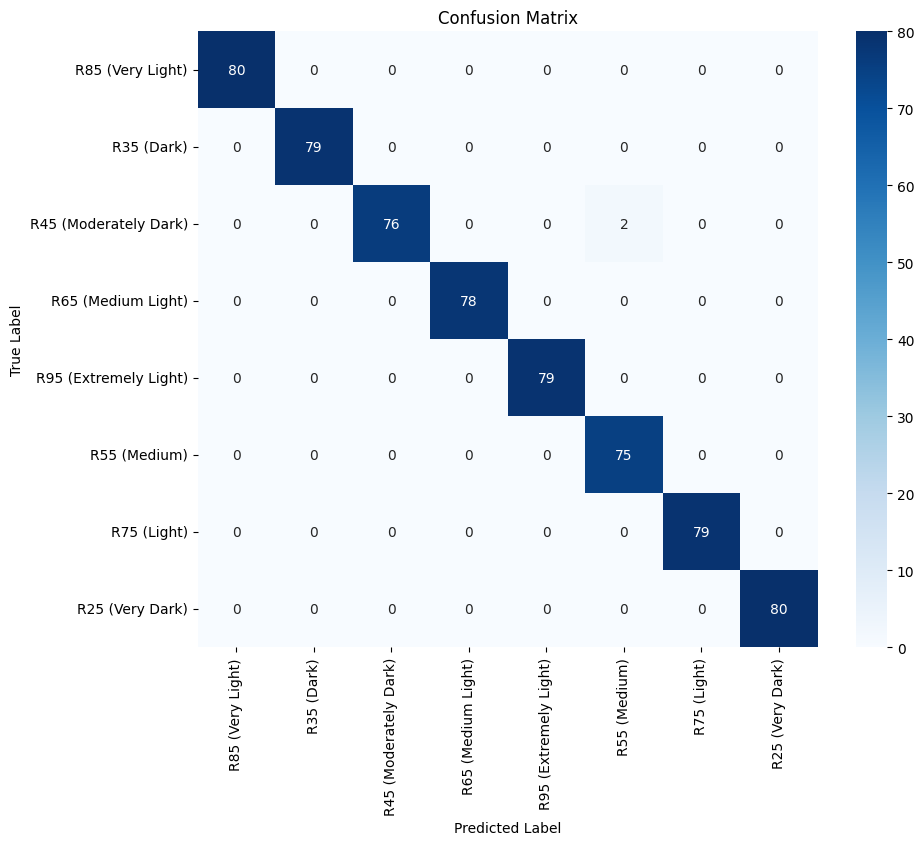

In [39]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Increase Contrast

In [40]:
# Load images with Geometric Transformation

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

num_classes = len(train_df['label'].unique())

# One-hot encode labels
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

# Reshape the images to the desired shape
contrasted_train = reshape_images(contrasted_train)
contrasted_val = reshape_images(contrasted_val)
contrasted_test = reshape_images(contrasted_test)

In [41]:
# reset weight
model.load_weights(initial_weights_filepath)

# Train the CNN model on unprocessed images (only normalized)
history_contrast= model.fit(
    contrasted_train, train_labels,
    validation_data=(contrasted_val, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,   
    verbose=1,
)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(contrasted_test, test_labels)
print(f"Test Accuracy without preprocessing: {test_accuracy}")

Epoch 1/25
126/126 [==============================] - 13s 105ms/step - loss: 1.3029 - accuracy: 0.7495 - val_loss: 0.2477 - val_accuracy: 0.9104
Epoch 2/25
126/126 [==============================] - 12s 99ms/step - loss: 0.1901 - accuracy: 0.9253 - val_loss: 0.1953 - val_accuracy: 0.9303
Epoch 3/25
126/126 [==============================] - 13s 99ms/step - loss: 0.0803 - accuracy: 0.9731 - val_loss: 0.0779 - val_accuracy: 0.9761
Epoch 4/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0464 - accuracy: 0.9890 - val_loss: 0.0760 - val_accuracy: 0.9721
Epoch 5/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0460 - accuracy: 0.9885 - val_loss: 0.1150 - val_accuracy: 0.9562
Epoch 6/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0256 - accuracy: 0.9955 - val_loss: 0.0861 - val_accuracy: 0.9701
Epoch 7/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0200 - accuracy: 0.9965 - val_loss: 0.0416 - val_accura

In [42]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(contrasted_test, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(contrasted_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


20/20 [==============================] - 3s 132ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       1.00      1.00      1.00        80
           R35 (Dark)       0.99      0.97      0.98        79
R45 (Moderately Dark)       0.95      0.95      0.95        78
   R65 (Medium Light)       1.00      0.97      0.99        78
R95 (Extremely Light)       1.00      1.00      1.00        79
         R55 (Medium)       0.96      0.97      0.97        75
          R75 (Light)       0.98      1.00      0.99        79
      R25 (Very Dark)       1.00      1.00      1.00        80

             accuracy                           0.98       628
            macro avg       0.98      0.98      0.98       628
         weighted avg       0.98      0.98      0.98       628

Accuracy: 0.9841
Precision: 0.9842
Recall: 0.9841
F1-Score: 0.9841


In [43]:
# Save history for comparison later
history_contrast_dict = {
    'accuracy': history_contrast.history['accuracy'],
    'val_accuracy': history_contrast.history['val_accuracy'],
    'loss': history_contrast.history['loss'],
    'val_loss': history_contrast.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


#### Confusion Matrix

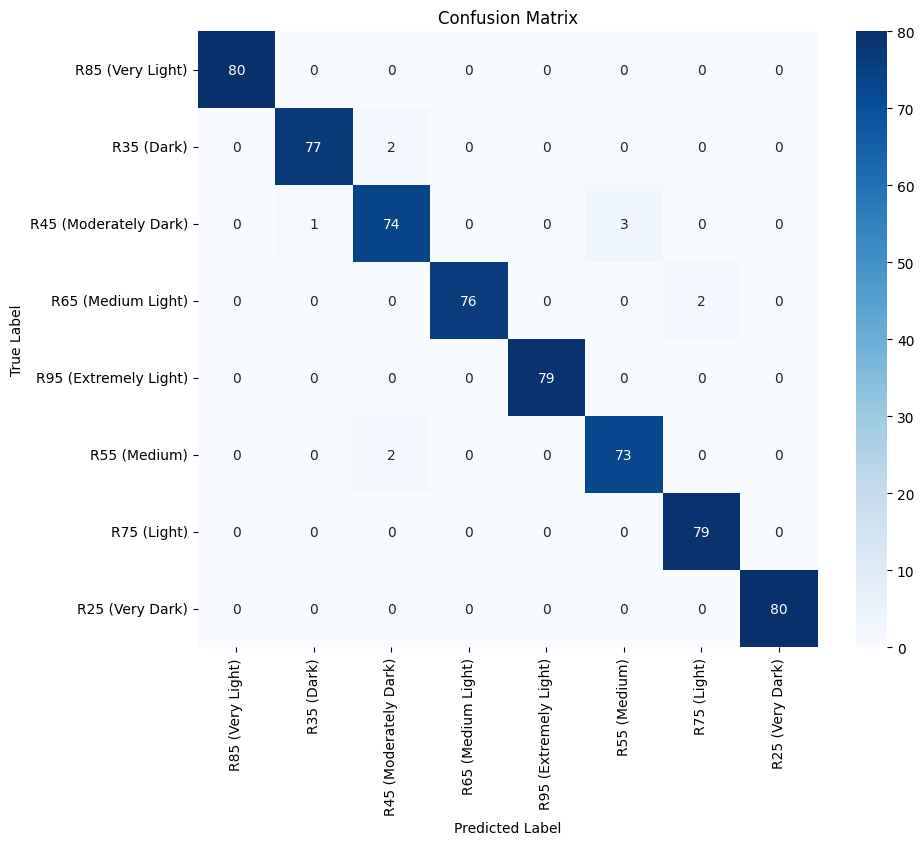

In [44]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### All Prepro Methods

In [45]:
# Load images with Geometric Transformation

# Create a mapping from class names to integers
label_mapping = {label: idx for idx, label in enumerate(train_df['label'].unique())}

# Apply this mapping to convert string labels to integer labels
train_labels = train_df['label'].map(label_mapping).values
val_labels = val_df['label'].map(label_mapping).values
test_labels = test_df['label'].map(label_mapping).values

num_classes = len(train_df['label'].unique())

# One-hot encode labels
train_labels = one_hot_encode_labels(train_labels, num_classes)
val_labels = one_hot_encode_labels(val_labels, num_classes)
test_labels = one_hot_encode_labels(test_labels, num_classes)

# Reshape the images to the desired shape
all_train = reshape_images(all_train)
all_val = reshape_images(all_val)
all_test = reshape_images(all_test)

In [46]:
# reset weight
model.load_weights(initial_weights_filepath)

# Train the CNN model on unprocessed images (only normalized)
history_all= model.fit(
    all_train, train_labels,
    validation_data=(all_val, val_labels),
    epochs=num_epochs,
    batch_size=batchsize,   
    verbose=1,
)

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(all_test, test_labels)
print(f"Test Accuracy without preprocessing: {test_accuracy}")

Epoch 1/25
126/126 [==============================] - 13s 106ms/step - loss: 1.0958 - accuracy: 0.7480 - val_loss: 0.2382 - val_accuracy: 0.9303
Epoch 2/25
126/126 [==============================] - 13s 104ms/step - loss: 0.1445 - accuracy: 0.9532 - val_loss: 0.1788 - val_accuracy: 0.9382
Epoch 3/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0761 - accuracy: 0.9786 - val_loss: 0.0778 - val_accuracy: 0.9721
Epoch 4/25
126/126 [==============================] - 12s 99ms/step - loss: 0.0461 - accuracy: 0.9880 - val_loss: 0.0857 - val_accuracy: 0.9721
Epoch 5/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0430 - accuracy: 0.9895 - val_loss: 0.1342 - val_accuracy: 0.9562
Epoch 6/25
126/126 [==============================] - 13s 100ms/step - loss: 0.0253 - accuracy: 0.9950 - val_loss: 0.0608 - val_accuracy: 0.9801
Epoch 7/25
126/126 [==============================] - 13s 99ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 0.0562 - val_accur

In [47]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming your model is already trained
# Evaluate the model for accuracy
loss, accuracy = model.evaluate(all_test, test_labels, verbose=0)

# Predict class probabilities and convert them to predicted class indices
y_pred = model.predict(all_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the true labels back from one-hot encoded form to class indices
y_true = np.argmax(test_labels, axis=1)

# Calculate Precision, Recall, F1-Score using classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_mapping.keys())))

# You can also manually extract precision, recall, and F1-score as follows:
report = classification_report(y_true, y_pred_classes, output_dict=True)

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


20/20 [==============================] - 2s 125ms/step
Classification Report:
                       precision    recall  f1-score   support

     R85 (Very Light)       1.00      1.00      1.00        80
           R35 (Dark)       0.97      0.99      0.98        79
R45 (Moderately Dark)       0.97      0.95      0.96        78
   R65 (Medium Light)       1.00      1.00      1.00        78
R95 (Extremely Light)       1.00      1.00      1.00        79
         R55 (Medium)       0.97      0.99      0.98        75
          R75 (Light)       1.00      1.00      1.00        79
      R25 (Very Dark)       1.00      1.00      1.00        80

             accuracy                           0.99       628
            macro avg       0.99      0.99      0.99       628
         weighted avg       0.99      0.99      0.99       628

Accuracy: 0.9904
Precision: 0.9904
Recall: 0.9904
F1-Score: 0.9904


In [48]:
# Save history for comparison later
history_all_dict = {
    'accuracy': history_all.history['accuracy'],
    'val_accuracy': history_all.history['val_accuracy'],
    'loss': history_all.history['loss'],
    'val_loss': history_all.history['val_loss']
}

# You can save this to a file if needed or keep it for comparison with other methods


#### Confusion Matrix

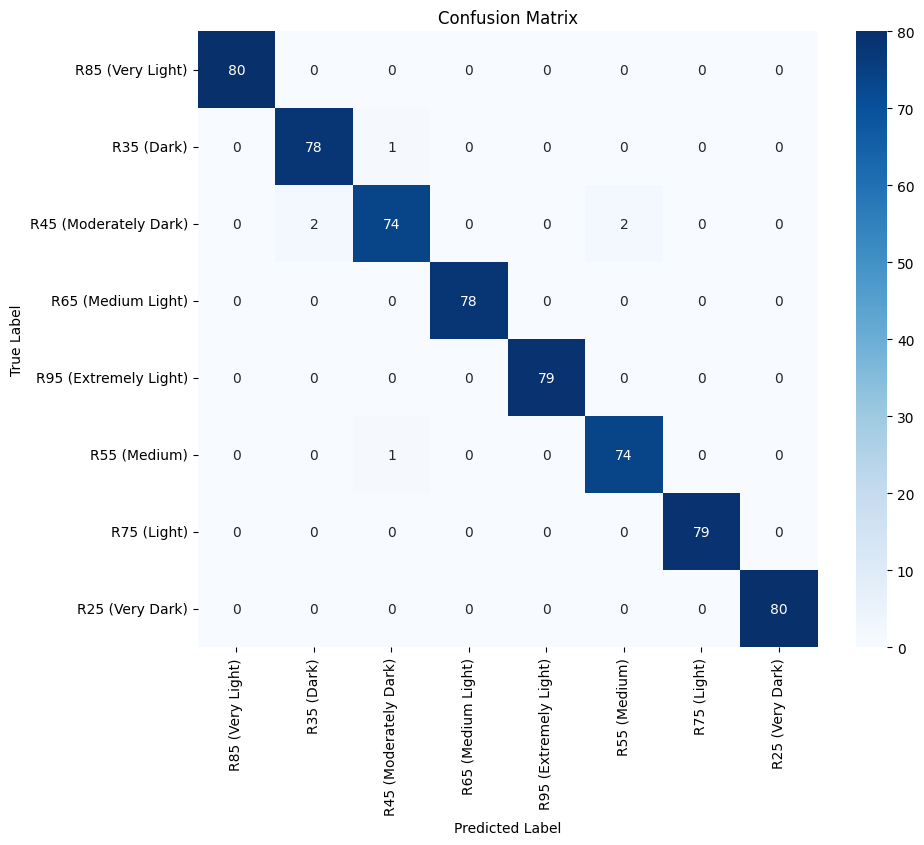

In [49]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Perbandingan Performa

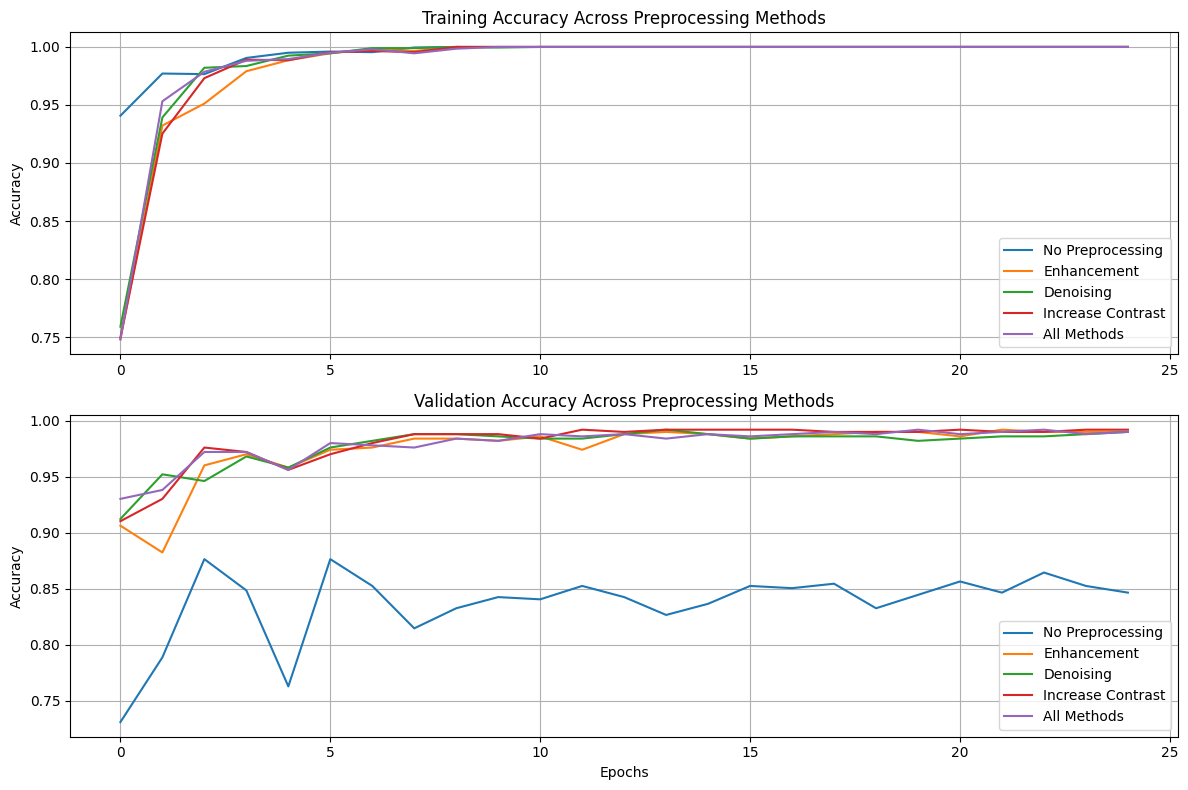

In [50]:
# Function to plot training and validation accuracy separately for different preprocessing methods
def plot_separate_histories(histories, labels, metric='accuracy', val_metric='val_accuracy'):
    plt.figure(figsize=(12, 8))

    # Plot training accuracy
    plt.subplot(2, 1, 1)  # Create a 2-row, 1-column layout, this is the 1st plot
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=label)
    plt.title('Training Accuracy Across Preprocessing Methods')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(2, 1, 2)  # This is the 2nd plot
    for history, label in zip(histories, labels):
        plt.plot(history.history[val_metric], label=label)
    plt.title('Validation Accuracy Across Preprocessing Methods')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Show both plots
    plt.tight_layout()  # Adjusts the layout to prevent overlap
    plt.show()

# List of histories
histories = [
    history_no_preprocessing, 
    history_enhance, 
    history_denoise, 
    history_contrast,
    history_all 
]

# Labels corresponding to each history (for legend)
labels = [
    'No Preprocessing', 
    'Enhancement', 
    'Denoising', 
    'Increase Contrast',
    'All Methods', 
]

# Call the plot function
plot_separate_histories(histories, labels)


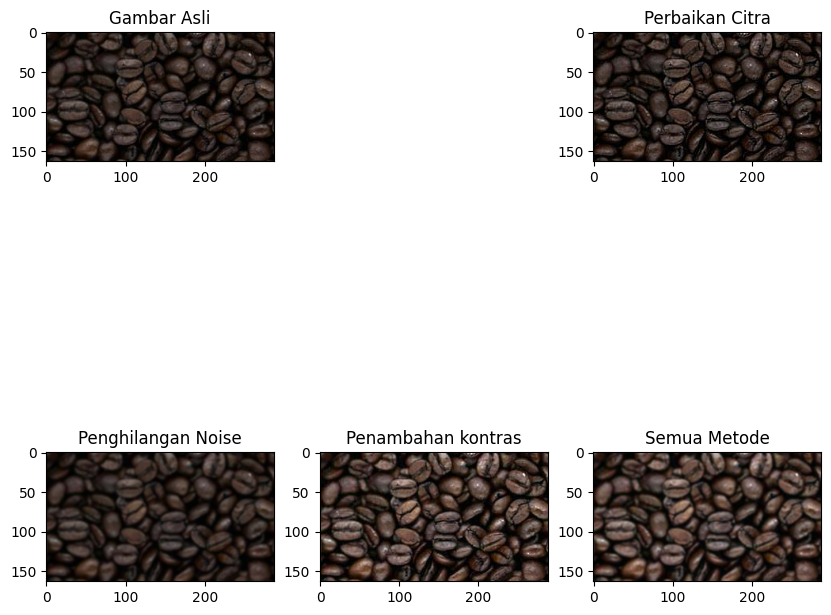

In [51]:
def plot_preprocessed_images(image_path):
    img = plt.imread(image_path)
    plt.figure(figsize=(10, 10))

    # Gambar Asli
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title('Gambar Asli')

    # Perbaikan Citra
    plt.subplot(2, 3, 3)
    plt.imshow(enhance_image(img), cmap='gray')
    plt.title('Perbaikan Citra')

    # Penghilangan Noise
    plt.subplot(2, 3, 4)
    plt.imshow(reduce_noise(img))
    plt.title('Penghilangan Noise')

    # Increase COntrast
    plt.subplot(2, 3, 5)
    plt.imshow(increase_contrast(img))
    plt.title('Penambahan kontras')

    
    plt.subplot(2, 3, 6)
    plt.imshow(
        increase_contrast(reduce_noise(enhance_image(img)))
        )
    plt.title('Semua Metode')

    plt.show()

plot_preprocessed_images(os.path.join(base_dir, 'R25 (very Dark)', os.listdir(os.path.join(base_dir, 'R25 (very Dark)'))[20]))